### Import libraries

In [1]:
import sys
import os
import gc
import numpy as np
import pandas as pd 
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

In [2]:
home = os.path.expanduser("~")
sys.path.append(f"{home}/Documents/projects/CarPriceRegression/Machine_Learning/scripts/")

In [91]:
from util import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
set_gpu_limit(6)

### Split none onehot encoded data into train and test for categorical embedding

In [7]:
data = pd.read_csv(f"{home}/Documents/projects/CarPriceRegression/Processed_Data/car_data_merged.csv")
features, y = data.drop("price",axis=1), data.price
X_train, X_test, y_train, y_test = train_test_split(features,y,test_size=0.1,random_state=2020)
X_train,X_dev,y_train,y_dev = train_test_split(X_train,y_train,test_size=0.11,random_state=2020)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99186 entries, 0 to 99185
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   model          99186 non-null  object
 1   price          99186 non-null  int64 
 2   transmission   99186 non-null  object
 3   fuelType       99186 non-null  object
 4   binned_year    99186 non-null  int64 
 5   mil_cat        99186 non-null  int64 
 6   binned_mpg     99186 non-null  int64 
 7   engine_binned  99186 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 6.1+ MB


### We will embed columns model, transmission, and fuelType

--- 

### Garbage collect

In [8]:
gc.collect()
%reset -f out

Flushing output cache (0 entries)


### Setting up some constants

In [9]:
EMBED_COLS = ["model","transmission","fuelType"]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 1e-3
numeric_size = [64,32]
model_size = [1024,512,256]
DROPOUT= [0.2,0.2]
METRICS = ["MAPE","MAE"]

In [10]:
earlystop = tfk.callbacks.EarlyStopping(monitor="val_loss",mode="min",
                                        patience=10,verbose=1,restore_best_weights=True)

### train, dev, and test data for NN

* model embed model input 
* transmission embed model input
* fuelType embed model input 
* numeric input data 

In [11]:
train_input,dev_input,test_input = cate_embed_process(X_train,X_dev,X_test,EMBED_COLS)

In [22]:
base_embed_model = embed_model_setup(EMBED_COLS,X_train,numeric_size,model_size,DROPOUT,METRICS,lr)

In [23]:
base_embed_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 4)]          0                                            
____________________________________________________________________________________________

In [13]:
# history = base_embed_model.fit(train_input,y_train, epochs=MAX_EPOCH,shuffle=True,
#                          verbose = 1, validation_data=(dev_input,y_dev),
#                          callbacks=[earlystop])

In [14]:
# base_embed_model.save("cate_embed_base_model.h5")

In [15]:
base_embed_model = tfk.models.load_model("cate_embed_base_model.h5",custom_objects={"leaky_relu":tf.nn.leaky_relu})

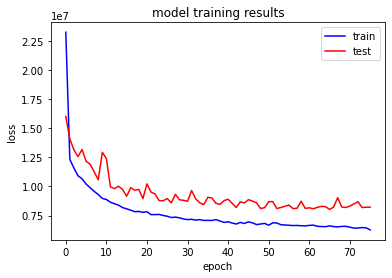

In [66]:
# plot_metrics(history,"loss")

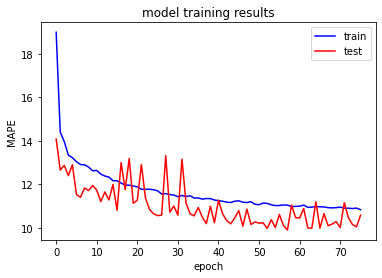

In [67]:
# plot_metrics(history,"MAPE")

### Let's check model results 

In [17]:
regression_metrics(base_embed_model,train_input,y_train,test_input,y_test,256)

,r2_score,rmse,price_diff_abs_max
train,0.943838,2337.606449,695.343624
test,0.937741,2406.883565,408.698918


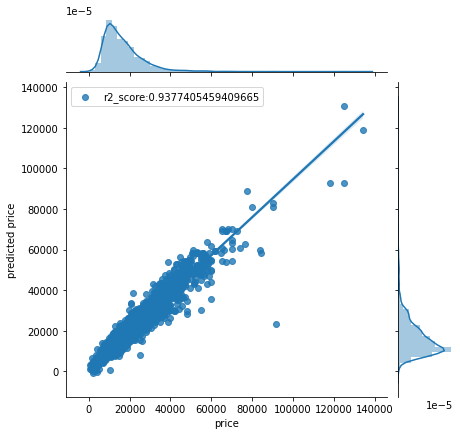

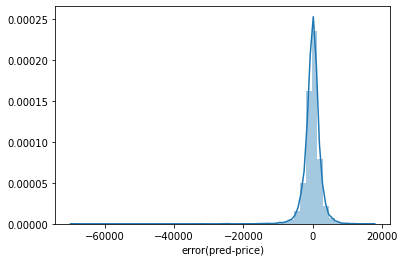

In [18]:
plot_pred_price(base_embed_model,test_input,y_test,batch_size=BATCH_SIZE)

In [19]:
price_table = price_diff(base_embed_model,X_test,y_test,256, 1, test_input)

In [20]:
price_table.sort_values("price_diff_abs",ascending=False).head(20)

,model,transmission,fuelType,binned_year,mil_cat,binned_mpg,engine_binned,price_diff_pct,price_diff_abs
39978,A Class,Manual,Petrol,1,5,1,0,-408.698918,408.698918
40171,A Class,Automatic,Petrol,1,4,2,0,-251.181017,251.181017
20056,Beetle,Manual,Petrol,1,4,2,0,-191.598764,191.598764
12301,Golf,Manual,Petrol,2,4,2,0,-172.129982,172.129982
2450,Yaris,Automatic,Petrol,0,4,2,0,155.427723,155.427723
85142,Z4,Automatic,Petrol,1,4,1,1,-126.068407,126.068407
98752,A6,Automatic,Diesel,2,4,2,1,-113.813571,113.813571
44326,Corsa,Manual,Petrol,1,5,2,0,105.695672,105.695672
39953,SLK,Automatic,Petrol,0,5,1,1,103.857876,103.857876
98626,TT,Manual,Petrol,1,5,1,0,-97.500380,97.500380


### Similar to other models, cars that are old with high mileage tend to be over predicted by the model 

### Let's try a bigger model and see if it helps and increase embed size with slower learning rate 

In [12]:
EMBED_COLS = ["model","transmission","fuelType"]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 5e-4
numeric_size = [128,64]
model_size = [1024,512,256]
DROPOUT= [0.1,0.1]
METRICS = ["MAPE","MAE"]

In [13]:
bigger_embed_model = embed_model_setup(EMBED_COLS,X_train,numeric_size,model_size,DROPOUT,METRICS,lr,1.5)

In [14]:
bigger_embed_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 4)]          0                                            
______________________________________________________________________________________________

In [15]:
history = bigger_embed_model.fit(train_input,y_train, epochs=MAX_EPOCH,shuffle=True,
                         verbose = 1, validation_data=(dev_input,y_dev),
                         callbacks=[earlystop])

Epoch 1/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 28979676.0000 - MAPE: 21.7639 - MAE: 3223.3804 - val_loss: 17254088.0000 - val_MAPE: 14.4402 - val_MAE: 2304.4978
Epoch 2/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 12618083.0000 - MAPE: 14.5515 - MAE: 2220.3391 - val_loss: 15733136.0000 - val_MAPE: 15.6936 - val_MAE: 2422.4551
Epoch 3/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 11616164.0000 - MAPE: 13.9140 - MAE: 2132.0256 - val_loss: 14173748.0000 - val_MAPE: 14.0395 - val_MAE: 2152.5342
Epoch 4/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 11340377.0000 - MAPE: 13.8072 - MAE: 2110.4553 - val_loss: 13520230.0000 - val_MAPE: 13.6504 - val_MAE: 2112.9167
Epoch 5/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 10983375.0000 - MAPE: 13.5098 - MAE: 2068.5950 - val_loss: 13223516.0000 - val_MAPE: 12.4741 - val_MAE: 2024.2061
Epoch 6/1000
2483/2483 [================

Epoch 44/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 6799728.0000 - MAPE: 11.1371 - MAE: 1724.1407 - val_loss: 8816131.0000 - val_MAPE: 10.5115 - val_MAE: 1722.8879
Epoch 45/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 6775545.5000 - MAPE: 11.0131 - MAE: 1710.2152 - val_loss: 8842132.0000 - val_MAPE: 10.4450 - val_MAE: 1715.9326
Epoch 46/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 6905725.5000 - MAPE: 11.1005 - MAE: 1723.1843 - val_loss: 8509251.0000 - val_MAPE: 10.3937 - val_MAE: 1682.7719
Epoch 47/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 6800632.0000 - MAPE: 11.0294 - MAE: 1710.5721 - val_loss: 8763252.0000 - val_MAPE: 10.2772 - val_MAE: 1678.2451
Epoch 48/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 6745167.0000 - MAPE: 10.9851 - MAE: 1705.0867 - val_loss: 9135737.0000 - val_MAPE: 10.2728 - val_MAE: 1723.0625
Epoch 49/1000
2483/2483 [====================

Epoch 87/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 6129263.5000 - MAPE: 10.5635 - MAE: 1637.1017 - val_loss: 8716286.0000 - val_MAPE: 12.1802 - val_MAE: 1815.0000
Epoch 88/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 6069425.5000 - MAPE: 10.5172 - MAE: 1629.4579 - val_loss: 8072809.5000 - val_MAPE: 9.8329 - val_MAE: 1611.6552
Epoch 89/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 6064676.0000 - MAPE: 10.5311 - MAE: 1630.9105 - val_loss: 8084976.0000 - val_MAPE: 9.8955 - val_MAE: 1611.9518
Epoch 90/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 6112167.5000 - MAPE: 10.5493 - MAE: 1632.4923 - val_loss: 8021693.0000 - val_MAPE: 10.0182 - val_MAE: 1607.4303
Epoch 91/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 6073199.5000 - MAPE: 10.5535 - MAE: 1629.2549 - val_loss: 8395551.0000 - val_MAPE: 10.0294 - val_MAE: 1611.9369
Epoch 92/1000
2483/2483 [======================

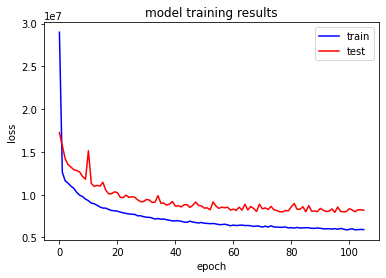

In [16]:
plot_metrics(history,"loss")

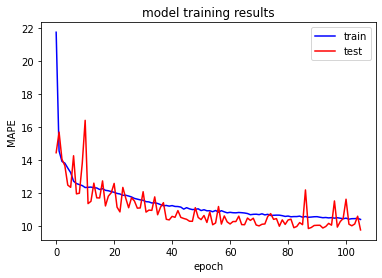

In [17]:
plot_metrics(history,"MAPE")

In [18]:
bigger_embed_model.save("bigger_embed.h5")

In [19]:
regression_metrics(bigger_embed_model,train_input,y_train,test_input,y_test,256)

,r2_score,rmse,price_diff_abs_max
train,0.944966,2314.002199,523.42940
test,0.937984,2402.164960,256.38623


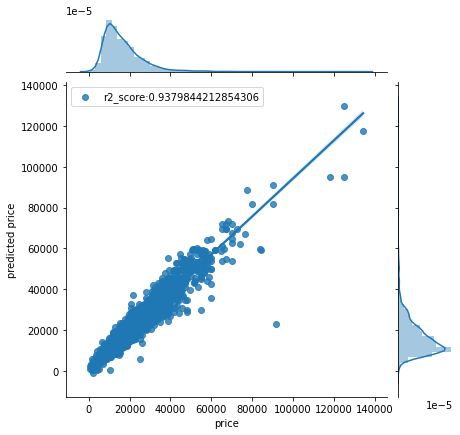

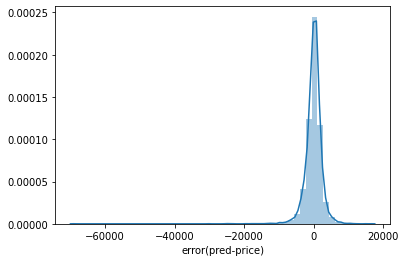

In [20]:
plot_pred_price(bigger_embed_model,test_input,y_test,batch_size=BATCH_SIZE)

In [21]:
price_diff(bigger_embed_model,X_test,y_test,256, 1, test_input).sort_values("price_diff_abs",ascending=False).head(20)

,model,transmission,fuelType,binned_year,mil_cat,binned_mpg,engine_binned,price_diff_pct,price_diff_abs
39978,A Class,Manual,Petrol,1,5,1,0,-256.386230,256.386230
40171,A Class,Automatic,Petrol,1,4,2,0,-218.119900,218.119900
2450,Yaris,Automatic,Petrol,0,4,2,0,162.381595,162.381595
20056,Beetle,Manual,Petrol,1,4,2,0,-147.410776,147.410776
12301,Golf,Manual,Petrol,2,4,2,0,-138.865941,138.865941
85142,Z4,Automatic,Petrol,1,4,1,1,-124.707604,124.707604
41293,Corsa,Manual,Diesel,2,4,4,0,-121.957359,121.957359
98752,A6,Automatic,Diesel,2,4,2,1,-118.589465,118.589465
52118,Zafira,Manual,Petrol,0,3,2,0,97.535361,97.535361
39953,SLK,Automatic,Petrol,0,5,1,1,93.156816,93.156816


### Performance is slightly better but still have bin year and mil category issues. 

### Try embed other binned numerical features and see if the performance improves 

In [22]:
EMBED_COLS = ["model","transmission","fuelType","binned_year","mil_cat","binned_mpg","engine_binned"]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 5e-4
numeric_size = [128,64]
model_size = [1024,512,256]
DROPOUT= [0.1,0.1]
METRICS = ["MAPE","MAE"]

In [23]:
train_input_2,dev_input_2,test_input_2 = cate_embed_process(X_train,X_dev,X_test,EMBED_COLS)

In [24]:
all_embed_model = embed_model_setup(EMBED_COLS,X_train,numeric_size,model_size,DROPOUT,METRICS,lr,2)

In [25]:
all_embed_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 1)]          0                                            
____________________________________________________________________________________________

In [26]:
earlystop = tfk.callbacks.EarlyStopping(monitor="val_loss",mode="min",patience=10,verbose=1,restore_best_weights=True)

In [27]:
history = all_embed_model.fit(train_input_2,y_train, epochs=MAX_EPOCH,shuffle=True,verbose = 1, 
                              validation_data=(dev_input_2,y_dev),callbacks=[earlystop])

Epoch 1/1000
2483/2483 [==============================] - 9s 3ms/step - loss: 33075078.0000 - MAPE: 21.8142 - MAE: 3234.6482 - val_loss: 19875362.0000 - val_MAPE: 17.9519 - val_MAE: 2629.4084
Epoch 2/1000
2483/2483 [==============================] - 8s 3ms/step - loss: 14605862.0000 - MAPE: 16.1937 - MAE: 2381.9077 - val_loss: 16499187.0000 - val_MAPE: 15.6015 - val_MAE: 2348.8428
Epoch 3/1000
2483/2483 [==============================] - 9s 3ms/step - loss: 11885021.0000 - MAPE: 13.9901 - MAE: 2115.0552 - val_loss: 13699848.0000 - val_MAPE: 13.2812 - val_MAE: 2085.8748
Epoch 4/1000
2483/2483 [==============================] - 8s 3ms/step - loss: 10504927.0000 - MAPE: 12.9252 - MAE: 1993.8745 - val_loss: 12911933.0000 - val_MAPE: 13.2169 - val_MAE: 2074.5059
Epoch 5/1000
2483/2483 [==============================] - 8s 3ms/step - loss: 9908701.0000 - MAPE: 12.4531 - MAE: 1953.1433 - val_loss: 12243061.0000 - val_MAPE: 11.7524 - val_MAE: 1941.7806
Epoch 6/1000
2483/2483 [=================

Epoch 44/1000
2483/2483 [==============================] - 8s 3ms/step - loss: 6279089.0000 - MAPE: 10.5377 - MAE: 1647.8123 - val_loss: 8403065.0000 - val_MAPE: 10.0873 - val_MAE: 1645.8842
Epoch 45/1000
2483/2483 [==============================] - 8s 3ms/step - loss: 6223326.5000 - MAPE: 10.5160 - MAE: 1642.7471 - val_loss: 8441406.0000 - val_MAPE: 10.1306 - val_MAE: 1663.0227
Epoch 46/1000
2483/2483 [==============================] - 8s 3ms/step - loss: 6249028.5000 - MAPE: 10.5228 - MAE: 1641.5537 - val_loss: 8120816.5000 - val_MAPE: 10.1899 - val_MAE: 1638.2091
Epoch 47/1000
2483/2483 [==============================] - 8s 3ms/step - loss: 6218376.0000 - MAPE: 10.4669 - MAE: 1636.9225 - val_loss: 8155870.0000 - val_MAPE: 9.9742 - val_MAE: 1625.7153
Epoch 48/1000
2483/2483 [==============================] - 8s 3ms/step - loss: 6185889.0000 - MAPE: 10.5016 - MAE: 1638.2736 - val_loss: 8203199.5000 - val_MAPE: 10.6553 - val_MAE: 1676.6576
Epoch 49/1000
2483/2483 [=====================

2483/2483 [==============================] - 8s 3ms/step - loss: 5763620.5000 - MAPE: 10.1776 - MAE: 1586.6393 - val_loss: 8012242.5000 - val_MAPE: 10.3799 - val_MAE: 1622.7502
Epoch 00087: early stopping


In [30]:
all_embed_model.save("All_embed.h5")

In [31]:
all_embed_model = tfk.models.load_model("All_embed.h5",custom_objects={"leaky_relu":tf.nn.leaky_relu})

In [32]:
regression_metrics(all_embed_model,train_input_2,y_train,test_input_2,y_test,256)

,r2_score,rmse,price_diff_abs_max
train,0.945571,2301.243274,508.741321
test,0.938948,2383.437645,249.884352


In [33]:
price_diff(all_embed_model,X_test,y_test,256, 1, test_input_2).sort_values("price_diff_abs",ascending=False).head(20)

,model,transmission,fuelType,binned_year,mil_cat,binned_mpg,engine_binned,price_diff_pct,price_diff_abs
39978,A Class,Manual,Petrol,1,5,1,0,-249.884352,249.884352
20056,Beetle,Manual,Petrol,1,4,2,0,-172.981821,172.981821
71817,Focus,Manual,Petrol,1,5,1,0,-166.743652,166.743652
40171,A Class,Automatic,Petrol,1,4,2,0,-155.478678,155.478678
12301,Golf,Manual,Petrol,2,4,2,0,-137.297379,137.297379
98752,A6,Automatic,Diesel,2,4,2,1,-136.475218,136.475218
85142,Z4,Automatic,Petrol,1,4,1,1,-127.399172,127.399172
98626,TT,Manual,Petrol,1,5,1,0,-117.300590,117.300590
41293,Corsa,Manual,Diesel,2,4,4,0,-114.850792,114.850792
39937,S Class,Automatic,Diesel,2,3,2,1,-100.405210,100.405210


### Slightly improved, still have same issues with older year. Let's import original raw data

In [34]:
data_raw = pd.read_csv(f"{home}/Documents/projects/CarPriceRegression/Processed_Data/car_data_raw.csv").drop("brand",axis=1)
features_raw, y_raw = data_raw.drop("price",axis=1), data_raw.price
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(features_raw,y_raw,test_size=0.1,random_state=2020)
X_train_r,X_dev_r,y_train_r,y_dev_r = train_test_split(X_train_r,y_train_r,test_size=0.11,random_state=2020)

In [35]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99186 entries, 0 to 99185
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         99186 non-null  object 
 1   year          99186 non-null  int64  
 2   price         99186 non-null  int64  
 3   transmission  99186 non-null  object 
 4   mileage       99186 non-null  int64  
 5   fuelType      99186 non-null  object 
 6   mpg           99186 non-null  float64
 7   engineSize    99186 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 6.1+ MB


In [36]:
EMBED_COLS = ["model","transmission","fuelType","year"]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 5e-4
numeric_size = [128]
model_size = [1024,512,256]
DROPOUT= [0.1,0.1]
METRICS = ["MAPE","MAE"]

In [37]:
train_input_r,dev_input_r,test_input_r = cate_embed_process(X_train_r,X_dev_r,X_test_r,EMBED_COLS)

In [38]:
embed_model_r = embed_model_setup(EMBED_COLS,X_train_r,numeric_size,model_size,DROPOUT,METRICS,lr,2)

In [39]:
embed_model_r.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 1)]          0                                            
____________________________________________________________________________________________

In [40]:
history = embed_model_r.fit(train_input_r,y_train_r, epochs=MAX_EPOCH,shuffle=True,verbose = 1, 
                              validation_data=(dev_input_r,y_dev_r),callbacks=[earlystop])

Epoch 1/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 146735072.0000 - MAPE: 52.2365 - MAE: 7975.3198 - val_loss: 40822004.0000 - val_MAPE: 18.5482 - val_MAE: 3209.5420
Epoch 2/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 27358144.0000 - MAPE: 19.8441 - MAE: 3036.3569 - val_loss: 28022956.0000 - val_MAPE: 24.8845 - val_MAE: 3236.1033
Epoch 3/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 17982632.0000 - MAPE: 16.1399 - MAE: 2500.4507 - val_loss: 19191104.0000 - val_MAPE: 13.6482 - val_MAE: 2242.2656
Epoch 4/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 14671756.0000 - MAPE: 14.7560 - MAE: 2298.8247 - val_loss: 19629762.0000 - val_MAPE: 15.8127 - val_MAE: 2558.7642
Epoch 5/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 14115592.0000 - MAPE: 14.4196 - MAE: 2249.9597 - val_loss: 15012357.0000 - val_MAPE: 12.3543 - val_MAE: 2024.8568
Epoch 6/1000
2483/2483 [===============

Epoch 44/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 7706958.5000 - MAPE: 11.4653 - MAE: 1797.8831 - val_loss: 10514889.0000 - val_MAPE: 10.8491 - val_MAE: 1816.0890
Epoch 45/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 8092392.0000 - MAPE: 12.0311 - MAE: 1849.4971 - val_loss: 9589602.0000 - val_MAPE: 10.7890 - val_MAE: 1779.9321
Epoch 46/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 7612203.5000 - MAPE: 11.4718 - MAE: 1794.5923 - val_loss: 8655306.0000 - val_MAPE: 10.3080 - val_MAE: 1684.2786
Epoch 47/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 7506102.0000 - MAPE: 11.4072 - MAE: 1779.3296 - val_loss: 10598040.0000 - val_MAPE: 11.9548 - val_MAE: 1964.9629
Epoch 48/1000
2483/2483 [==============================] - 7s 3ms/step - loss: 8344981.5000 - MAPE: 12.2892 - MAE: 1884.4430 - val_loss: 9963448.0000 - val_MAPE: 13.0304 - val_MAE: 1966.9463
Epoch 49/1000
2483/2483 [==================

In [41]:
embed_model_r.save("model_embed_raw.h5")

In [42]:
embed_model_r = tfk.models.load_model("model_embed_raw.h5",custom_objects={"leaky_relu":tf.nn.leaky_relu})

In [43]:
regression_metrics(embed_model_r,train_input_r,y_train_r,test_input_r,y_test_r,256)

,r2_score,rmse,price_diff_abs_max
train,0.938446,2447.241317,820.422410
test,0.933769,2482.456106,358.908654


In [44]:
price_diff(embed_model_r,X_train_r,y_train_r,256, 1, train_input_r).sort_values("price_diff_abs",ascending=False).head(20)

,model,year,transmission,mileage,fuelType,mpg,engineSize,price_diff_pct,price_diff_abs
11984,Golf,2008,Manual,1,Diesel,53.3,1.9,-820.422410,820.422410
71819,Mondeo,2008,Manual,1,Diesel,47.9,2.0,-673.509896,673.509896
72016,Focus,2003,Manual,177644,Petrol,41.5,1.6,-479.600201,479.600201
20061,Beetle,2001,Automatic,1,Petrol,29.7,2.0,-434.429205,434.429205
83274,Z4,2014,Manual,31074,Petrol,41.5,2.0,-356.103071,356.103071
52100,Zafira,2013,Manual,279000,Diesel,55.4,1.7,-318.639428,318.639428
40170,A Class,2010,Manual,116126,Diesel,54.3,2.0,-292.883681,292.883681
44309,Corsa,2010,Manual,104000,Diesel,67.3,1.2,-291.460775,291.460775
6427,Avensis,2003,Manual,167054,Diesel,48.7,2.0,-284.634162,284.634162
39336,S Class,2001,Automatic,108800,Diesel,31.7,3.2,-280.147838,280.147838


### Let's use numeric binned data instead

In [45]:
combined = data.drop("binned_year",axis=1).merge(data_raw["year"],left_index=True,right_index=True)

In [46]:
features_c, y_c = combined.drop("price",axis=1), combined.price
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(features_c,y_c,test_size=0.1,random_state=2020)
X_train_c,X_dev_c,y_train_c,y_dev_c = train_test_split(X_train_c,y_train_c,test_size=0.11,random_state=2020)

In [78]:
EMBED_COLS = ["model","transmission","fuelType","year","mil_cat","binned_mpg","engine_binned"]
BATCH_SIZE = 256 
MAX_EPOCH = 1000
lr = 5e-4
numeric_size = [128,64]
model_size = [1024,512,256]
DROPOUT= [0.1,0.1]
METRICS = ["MAPE","MAE"]

In [48]:
train_input_c,dev_input_c,test_input_c = cate_embed_process(X_train_c,X_dev_c,X_test_c,EMBED_COLS)

In [49]:
embed_model_c = embed_model_setup(EMBED_COLS,X_train_c,numeric_size,model_size,DROPOUT,METRICS,lr,2)

In [50]:
embed_model_c.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 1)]          0                                            
____________________________________________________________________________________________

In [51]:
history = embed_model_c.fit(train_input_c,y_train_c, epochs=MAX_EPOCH,shuffle=True,verbose = 1, 
                              validation_data=(dev_input_c,y_dev_c),callbacks=[earlystop])

Epoch 1/1000
2483/2483 [==============================] - 9s 3ms/step - loss: 32233400.0000 - MAPE: 20.8308 - MAE: 3111.7422 - val_loss: 19007492.0000 - val_MAPE: 15.7576 - val_MAE: 2402.2466
Epoch 2/1000
2483/2483 [==============================] - 8s 3ms/step - loss: 13252815.0000 - MAPE: 14.9150 - MAE: 2211.7737 - val_loss: 14240597.0000 - val_MAPE: 13.1951 - val_MAE: 2046.7465
Epoch 3/1000
2483/2483 [==============================] - 8s 3ms/step - loss: 10446400.0000 - MAPE: 12.5621 - MAE: 1923.4744 - val_loss: 12489936.0000 - val_MAPE: 12.4006 - val_MAE: 1935.4604
Epoch 4/1000
2483/2483 [==============================] - 8s 3ms/step - loss: 9444464.0000 - MAPE: 11.6609 - MAE: 1836.3242 - val_loss: 12828916.0000 - val_MAPE: 12.8941 - val_MAE: 2039.1947
Epoch 5/1000
2483/2483 [==============================] - 8s 3ms/step - loss: 9063929.0000 - MAPE: 11.2232 - MAE: 1802.8196 - val_loss: 11552015.0000 - val_MAPE: 11.2858 - val_MAE: 1838.8915
Epoch 6/1000
2483/2483 [==================

2483/2483 [==============================] - 8s 3ms/step - loss: 5167829.5000 - MAPE: 9.2361 - MAE: 1485.1700 - val_loss: 7554169.5000 - val_MAPE: 9.1435 - val_MAE: 1505.5891
Epoch 45/1000
2483/2483 [==============================] - 8s 3ms/step - loss: 5238434.0000 - MAPE: 9.2040 - MAE: 1484.5844 - val_loss: 7587252.5000 - val_MAPE: 8.9283 - val_MAE: 1515.7357
Epoch 46/1000
2483/2483 [==============================] - 8s 3ms/step - loss: 5204145.0000 - MAPE: 9.2176 - MAE: 1483.5626 - val_loss: 7324021.5000 - val_MAPE: 8.9186 - val_MAE: 1467.6753
Epoch 47/1000
2483/2483 [==============================] - 8s 3ms/step - loss: 5169197.5000 - MAPE: 9.2162 - MAE: 1482.4496 - val_loss: 7470617.0000 - val_MAPE: 8.6572 - val_MAE: 1456.5359
Epoch 48/1000
2483/2483 [==============================] - 8s 3ms/step - loss: 5166973.0000 - MAPE: 9.2049 - MAE: 1479.9894 - val_loss: 7608175.0000 - val_MAPE: 8.6723 - val_MAE: 1483.6664
Epoch 49/1000
2483/2483 [==============================] - 8s 3ms/ste

In [52]:
embed_model_c.save("combined_embed_all.h5")

In [55]:
regression_metrics(embed_model_c,train_input_c,y_train_c,test_input_c,y_test_c,256)

,r2_score,rmse,price_diff_abs_max
train,0.955634,2077.664512,434.314820
test,0.948468,2189.729359,308.495493


In [56]:
price_diff(embed_model_c,X_train_c,y_train_c,256, 1, train_input_c).sort_values("price_diff_abs",ascending=False).head(20)

,model,transmission,fuelType,mil_cat,binned_mpg,engine_binned,year,price_diff_pct,price_diff_abs
11984,Golf,Manual,Diesel,0,3,0,2008,-434.314820,434.314820
71617,Fiesta,Manual,Petrol,4,2,0,2008,-360.526225,360.526225
71819,Mondeo,Manual,Diesel,0,2,0,2008,-324.522770,324.522770
83274,Z4,Manual,Petrol,3,2,0,2014,-299.934377,299.934377
39540,M Class,Semi-Auto,Petrol,5,1,1,2004,-261.601979,261.601979
40170,A Class,Manual,Diesel,5,3,0,2010,-247.735966,247.735966
20061,Beetle,Automatic,Petrol,0,1,0,2001,-244.498906,244.498906
52100,Zafira,Manual,Diesel,5,3,0,2013,-240.246276,240.246276
78800,X3,Semi-Auto,Diesel,2,3,0,2013,-204.178025,204.178025
29517,GLE Class,Semi-Auto,Diesel,4,2,1,2016,-202.322933,202.322933


### The binned numeric value did better than original numerica data. 

--- 

### Let's focus on binned numeric value with original year embed model and adjust learning rate first 

2483/2483 [==============================] - 9s 3ms/step - loss: nan - MAPE: nan - MAE: nan - val_loss: nan - val_MAPE: nan - val_MAE: nan


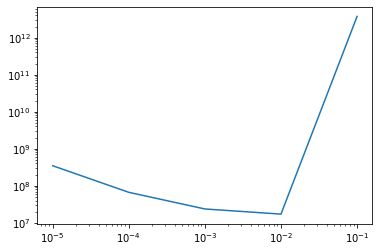

In [102]:
learning_rates = [1e-1,1e-2,1e-3,1e-4,1e-5,1e6]
mdl_setup = partial(embed_model_setup, EMBED_COLS,X_train_c,numeric_size,model_size,DROPOUT,METRICS,embed_size_multiplier=4.0)
learning_rate_search(learning_rates,mdl_setup,train_input_c,y_train_c,dev_input_c,y_dev_c,xlog=True,ylog=True)

2483/2483 [==============================] - 9s 4ms/step - loss: 17700136.0000 - MAPE: 16.3191 - MAE: 2511.7810 - val_loss: 13237571.0000 - val_MAPE: 13.1602 - val_MAE: 2046.8782


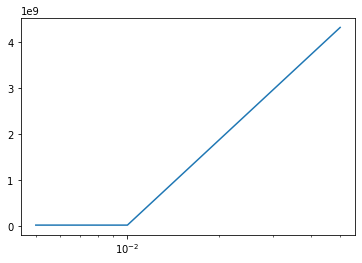

In [103]:
learning_rates = [5e-2,1e-2,5e-3]
learning_rate_search(learning_rates,mdl_setup,train_input_c,y_train_c,dev_input_c,y_dev_c,xlog=True,ylog=False)

In [115]:
mdl_setup(1e-3).summary()

Model: "model_72"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_500 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_501 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_502 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_503 (InputLayer)          [(None, 1)]          0                                            
___________________________________________________________________________________________

### learning rate of 0.01 seems to work the best

In [117]:
mdl_partial = partial(embed_model_setup, EMBED_COLS,X_train_c,numeric_size,model_size,DROPOUT,METRICS,0.001)

2483/2483 [==============================] - 9s 3ms/step - loss: 23610382.0000 - MAPE: 18.3621 - MAE: 2734.5315 - val_loss: 15713504.0000 - val_MAPE: 12.6126 - val_MAE: 2109.1677


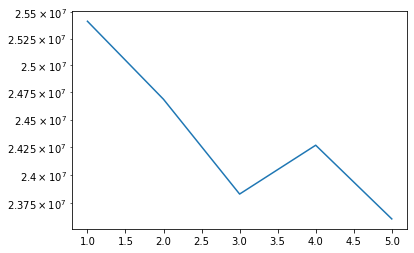

In [118]:
multipler = [1,2,3,4,5]
param_search(multipler,mdl_partial,train_input_c,y_train_c,dev_input_c,y_dev,xlog=False,ylog=True)

In [119]:
final_mdl = mdl_partial(3)

In [120]:
final_mdl.summary()

Model: "model_78"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_542 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_543 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_544 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_545 (InputLayer)          [(None, 1)]          0                                            
___________________________________________________________________________________________

In [121]:
history = final_mdl.fit(train_input_c,y_train_c, epochs=MAX_EPOCH,shuffle=True,verbose = 1, 
                              validation_data=(dev_input_c,y_dev_c),callbacks=[earlystop])

Epoch 1/1000
2483/2483 [==============================] - 9s 4ms/step - loss: 23967162.0000 - MAPE: 18.6208 - MAE: 2766.0229 - val_loss: 14958096.0000 - val_MAPE: 13.8949 - val_MAE: 2137.7278
Epoch 2/1000
2483/2483 [==============================] - 9s 3ms/step - loss: 10618083.0000 - MAPE: 12.7540 - MAE: 1970.2125 - val_loss: 12254283.0000 - val_MAPE: 11.3647 - val_MAE: 1868.5237
Epoch 3/1000
2483/2483 [==============================] - 9s 3ms/step - loss: 9440347.0000 - MAPE: 11.6880 - MAE: 1867.4332 - val_loss: 11708289.0000 - val_MAPE: 12.5056 - val_MAE: 1979.0981
Epoch 4/1000
2483/2483 [==============================] - 9s 3ms/step - loss: 8567510.0000 - MAPE: 11.3178 - MAE: 1813.8007 - val_loss: 12525029.0000 - val_MAPE: 15.9476 - val_MAE: 2280.1614
Epoch 5/1000
2483/2483 [==============================] - 9s 3ms/step - loss: 7902193.5000 - MAPE: 11.0702 - MAE: 1767.1935 - val_loss: 9692798.0000 - val_MAPE: 10.2830 - val_MAE: 1741.1617
Epoch 6/1000
2483/2483 [====================

2483/2483 [==============================] - 9s 3ms/step - loss: 5024112.5000 - MAPE: 9.1369 - MAE: 1465.3064 - val_loss: 7370920.5000 - val_MAPE: 8.7315 - val_MAE: 1473.6193
Epoch 45/1000
2483/2483 [==============================] - 9s 3ms/step - loss: 5005002.5000 - MAPE: 9.1334 - MAE: 1463.9663 - val_loss: 7154345.5000 - val_MAPE: 8.5820 - val_MAE: 1441.7356
Epoch 46/1000
2483/2483 [==============================] - 9s 3ms/step - loss: 5018680.5000 - MAPE: 9.1614 - MAE: 1466.5917 - val_loss: 7468171.0000 - val_MAPE: 9.0186 - val_MAE: 1477.9894
Epoch 47/1000
2483/2483 [==============================] - 9s 3ms/step - loss: 4923858.0000 - MAPE: 9.0585 - MAE: 1453.5757 - val_loss: 7215668.0000 - val_MAPE: 8.5006 - val_MAE: 1429.3971
Epoch 48/1000
2483/2483 [==============================] - 9s 3ms/step - loss: 4972905.0000 - MAPE: 9.0451 - MAE: 1453.7594 - val_loss: 7227536.5000 - val_MAPE: 8.3972 - val_MAE: 1424.5520
Epoch 49/1000
2483/2483 [==============================] - 9s 3ms/ste

In [123]:
final_mdl.save("final_embed_mdl.h5")

In [124]:
regression_metrics(final_mdl,train_input_c,y_train_c,test_input_c,y_test_c,256)

,r2_score,rmse,price_diff_abs_max
train,0.955851,2072.563220,325.528174
test,0.947841,2203.021612,146.468072


In [125]:
price_diff(final_mdl,X_train_c,y_train_c,256, 1, train_input_c).sort_values("price_diff_abs",ascending=False).head(20)

,model,transmission,fuelType,mil_cat,binned_mpg,engine_binned,year,price_diff_pct,price_diff_abs
71617,Fiesta,Manual,Petrol,4,2,0,2008,-325.528174,325.528174
11984,Golf,Manual,Diesel,0,3,0,2008,-324.850283,324.850283
83274,Z4,Manual,Petrol,3,2,0,2014,-289.236097,289.236097
71819,Mondeo,Manual,Diesel,0,2,0,2008,-235.616339,235.616339
71724,Mondeo,Manual,Petrol,5,1,0,2005,223.271973,223.271973
69280,Mondeo,Manual,Petrol,5,1,0,2002,222.849571,222.849571
39540,M Class,Semi-Auto,Petrol,5,1,1,2004,-222.601058,222.601058
20061,Beetle,Automatic,Petrol,0,1,0,2001,-205.635358,205.635358
39711,C Class,Automatic,Diesel,2,1,1,2002,-204.208037,204.208037
77582,Santa Fe,Manual,Petrol,4,1,1,2002,-199.888468,199.888468


### Conclusions

### More tuning on dropout and other params can enhance the models but embed gives the best results